In [1]:
from sklearn.preprocessing import StandardScaler as StdScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/home/ycc0526/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ycc0526/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ycc0526/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ycc0526/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
np.__version__

'1.17.3'

In [3]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [4]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    if lookback != 0:
        for i in range(len(X)-lookback+1):
            t = []
            for j in range(lookback):
                # Gather past records upto the lookback period
                t.append(X[[(i+j)], :])
            output_X.append(t)
    else:
        output_X = np.expand_dims(X,2)
    return np.array(output_X)

In [5]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def residuals(x):
    rList = []
    for i in range(len(x)):
        train_x_predictions = lstm_autoencoder.predict(np.expand_dims(x[i],0))
        rList.append(mean_squared_error(train_x_predictions[0][-1], x[i][-1]))
#         rList.append(mean_absolute_percentage_error(train_x_predictions[0][-1], x[i][-1]))
    return rList

# Preprocess

In [6]:
df = pd.read_csv('consolidate.csv',encoding='big5',index_col=0)
train_df = df[df['日期']<='2019/8/30'][df['時間']>'09:00:00'][df['時間']<'13:15:00'].drop(columns=['日期','時間'])
test_df = df[df['日期']>'2019/8/30'][df['時間']>'09:00:00'][df['時間']<'13:15:00'].drop(columns=['日期','時間'])
train_X_ = train_df.values
test_X_ = test_df.values
lookback=5

/usr/lib/python3.6/site-packages/IPython/kernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/IPython/kernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [7]:
scaler = StdScaler()
scaler.fit(train_X_)
train_X_ = scaler.transform(train_X_)
test_X_ = scaler.transform(test_X_)

In [8]:
train_X = temporalize(X = train_X_, y = train_X_, lookback = lookback)
test_X = temporalize(X = test_X_, y = test_X_, lookback = lookback)
# train_X = np.expand_dims(np.expand_dims(train_X,1),1)
# test_X = np.expand_dims(np.expand_dims(test_X,1),1)

In [9]:
train_X.shape

(1356, 5, 1, 45)

In [10]:
train_X=train_X.reshape((train_X.shape[0],lookback,train_X.shape[3]))
test_X=test_X.reshape((test_X.shape[0],lookback,test_X.shape[3]))

In [11]:
train_X.shape

(1356, 5, 45)

In [12]:
test_X[0][-1]

array([-1.05994481,  0.6396961 ,  0.57649446, -1.25262851,  3.99593138,
        3.56423431, -1.1034129 ,  1.4613676 ,  1.20755575, -1.21885131,
        1.21684548,  1.13926191, -0.2828921 ,  0.46220915,  0.44863083,
       -0.83151692,  0.09256124,  0.02307501, -1.52046304,  0.28884107,
        0.24931545, -0.05553801,  1.12275763,  1.04809834, -1.2393475 ,
        0.16231796,  0.12693155, -0.39492452, -0.24692561, -0.26941463,
       -1.19964098, -0.21237803, -0.24066372,  0.631858  ,  0.22820573,
        0.2932157 , -0.64612472, -0.0695854 , -0.09862814, -1.21250799,
        0.47842655,  0.37787253, -0.02198243,  0.75697566,  0.77325382])

In [13]:
test_X_[4]

array([-1.05994481,  0.6396961 ,  0.57649446, -1.25262851,  3.99593138,
        3.56423431, -1.1034129 ,  1.4613676 ,  1.20755575, -1.21885131,
        1.21684548,  1.13926191, -0.2828921 ,  0.46220915,  0.44863083,
       -0.83151692,  0.09256124,  0.02307501, -1.52046304,  0.28884107,
        0.24931545, -0.05553801,  1.12275763,  1.04809834, -1.2393475 ,
        0.16231796,  0.12693155, -0.39492452, -0.24692561, -0.26941463,
       -1.19964098, -0.21237803, -0.24066372,  0.631858  ,  0.22820573,
        0.2932157 , -0.64612472, -0.0695854 , -0.09862814, -1.21250799,
        0.47842655,  0.37787253, -0.02198243,  0.75697566,  0.77325382])

# Hyperparameters

In [14]:
timesteps =  train_X.shape[1] # equal to the lookback
n_features =  train_X.shape[2] # 

epochs = 5000
batch = 64
lr = 1e-3

In [15]:
int(timesteps)

5

In [16]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(64, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             28160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 32)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             8320      
____

# Train

In [17]:
# adam = Adam(lr)
# lstm_autoencoder.compile(loss='mse', optimizer=adam)

# cp = ModelCheckpoint(filepath="weights/lstm_autoencoder_classifier.h5",
#                                save_best_only=True,
#                                verbose=0)

# lstm_autoencoder_history = lstm_autoencoder.fit(train_X, train_X, 
#                                                 epochs=epochs, 
#                                                 verbose=2,
#                                                 batch_size=batch,
#                                                 validation_data=(test_X, test_X),
#                                                 callbacks=[cp]).history


In [18]:
# lstm_autoencoder_history_simplified = [i for i in lstm_autoencoder_history['val_loss'][1000:5000]]

In [19]:
# plt.plot(lstm_autoencoder_history_simplified)
# plt.show()

In [20]:
lstm_autoencoder.load_weights('weights/lstm_autoencoder_classifier-after_0830.h5')

In [21]:
test_X.shape

(236, 5, 45)

In [22]:
np.expand_dims(test_X,0).shape

(1, 236, 5, 45)

In [23]:
np.expand_dims(np.expand_dims(test_X[0],0),0).shape

(1, 1, 5, 45)

In [24]:
train_x_predictions = lstm_autoencoder.predict(np.expand_dims(test_X[1],0))

In [25]:
train_x_predictions[0][-1]

array([-0.75626546, -0.07276634, -0.10185058, -1.2421885 ,  0.8750736 ,
        0.6849233 , -1.2908765 ,  0.6987817 ,  0.44741318, -1.3138803 ,
        0.34205258,  0.30337054, -0.19794647,  0.22319332,  0.18399999,
       -0.54711425,  0.02657356,  0.01095096, -1.6699337 , -0.1247665 ,
       -0.12747121,  0.26854885,  0.20713077,  0.16797133, -1.0115807 ,
       -0.24502166, -0.26514238, -0.19527617, -0.15993725, -0.11539876,
       -1.1633095 , -0.07626904, -0.10593895,  0.45316547,  0.2962149 ,
        0.35661238, -1.0732946 ,  0.20929028,  0.10394744, -1.2437046 ,
        0.09186544,  0.02263623,  0.2759798 ,  0.31719455,  0.3284767 ],
      dtype=float32)

In [26]:
test_X[0][-1]

array([-1.05994481,  0.6396961 ,  0.57649446, -1.25262851,  3.99593138,
        3.56423431, -1.1034129 ,  1.4613676 ,  1.20755575, -1.21885131,
        1.21684548,  1.13926191, -0.2828921 ,  0.46220915,  0.44863083,
       -0.83151692,  0.09256124,  0.02307501, -1.52046304,  0.28884107,
        0.24931545, -0.05553801,  1.12275763,  1.04809834, -1.2393475 ,
        0.16231796,  0.12693155, -0.39492452, -0.24692561, -0.26941463,
       -1.19964098, -0.21237803, -0.24066372,  0.631858  ,  0.22820573,
        0.2932157 , -0.64612472, -0.0695854 , -0.09862814, -1.21250799,
        0.47842655,  0.37787253, -0.02198243,  0.75697566,  0.77325382])

In [27]:
train_x_predictions[0][-1]

array([-0.75626546, -0.07276634, -0.10185058, -1.2421885 ,  0.8750736 ,
        0.6849233 , -1.2908765 ,  0.6987817 ,  0.44741318, -1.3138803 ,
        0.34205258,  0.30337054, -0.19794647,  0.22319332,  0.18399999,
       -0.54711425,  0.02657356,  0.01095096, -1.6699337 , -0.1247665 ,
       -0.12747121,  0.26854885,  0.20713077,  0.16797133, -1.0115807 ,
       -0.24502166, -0.26514238, -0.19527617, -0.15993725, -0.11539876,
       -1.1633095 , -0.07626904, -0.10593895,  0.45316547,  0.2962149 ,
        0.35661238, -1.0732946 ,  0.20929028,  0.10394744, -1.2437046 ,
        0.09186544,  0.02263623,  0.2759798 ,  0.31719455,  0.3284767 ],
      dtype=float32)

In [28]:
np.square(train_x_predictions[0][-1]-test_X[0][-1]).mean()

0.5691129248233647

# Graph

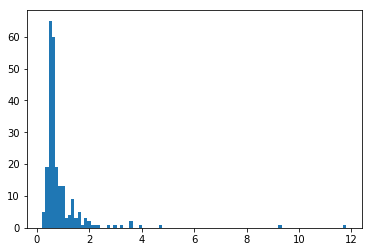

In [29]:
lstm_autoencoder.load_weights('weights/lstm_autoencoder_classifier-eliminate_extremes.h5')
r_eliminate = residuals(test_X)
plt.hist(r_eliminate, bins='auto')
plt.show()

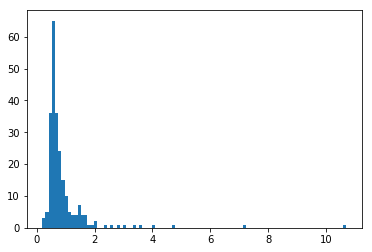

In [30]:
lstm_autoencoder.load_weights('weights/lstm_autoencoder_classifier-extreme_remains.h5')

r_remain = residuals(test_X)
plt.hist(r_remain, bins='auto')
plt.show()

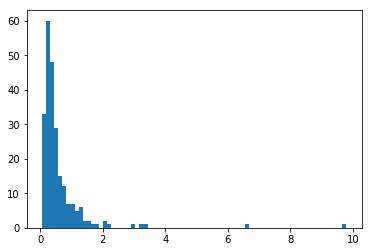

In [31]:
lstm_autoencoder.load_weights('weights/lstm_autoencoder_classifier-after_0830.h5')
r_eliminate2 = residuals(test_X)
plt.hist(r_eliminate2, bins='auto')
plt.show()

# Kurtosis

In [32]:
from scipy.stats import kurtosis
print('without eliminate: '+str(kurtosis(r_remain))+
      '\nwith eliminate: '+str(kurtosis(r_eliminate))+
      '\nwith eliminate2: '+str(kurtosis(r_eliminate2)))

without eliminate: 52.61761693723657
with eliminate: 55.40383694961851
with eliminate2: 61.12038672389758


# Compare

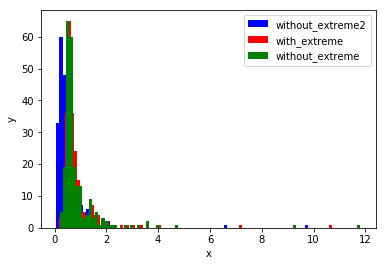

In [33]:
fig, ax = plt.subplots()
ax.hist(r_eliminate2, color="blue", label="without_extreme2", bins='auto')
ax.hist(r_remain, color="red", label="with_extreme", bins='auto')
ax.hist(r_eliminate, color="green", label="without_extreme", bins='auto')
ax.set_xlabel("x") # x标签
ax.set_ylabel("y") # y标签
ax.legend(); # 显示图例


# Number of Anomalies

In [34]:
count = 0
for i in r_eliminate2:
    if i >= np.quantile(r_eliminate2, q=0.95):
        count+=1
        
print(count)

12


In [35]:
count = 0
for i in r_remain:
    if i >= np.quantile(r_remain, q=0.95):
        count+=1
        
print(count)

12


In [36]:
pred_df = df[df['日期']>'2019/8/30'][df['時間']>'09:00:00'][df['時間']<'13:15:00']

/usr/lib/python3.6/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [37]:
pred_df.shape

(240, 47)

In [38]:
len(r_eliminate2)

236

In [39]:
pred_df['pred']=list(np.zeros(4))+list(r_eliminate2)

In [40]:
pred_df['diff']=pred_df['大立光_close'].diff()

In [41]:
pred_df['outlier']=pred_df['pred']>np.quantile(r_eliminate, q=0.95)

In [42]:
pred_df[['日期','時間','outlier','diff']][pred_df['outlier']==True]

,日期,時間,outlier,diff
1605,2019/9/2,09:45:00,True,-10.0
1624,2019/9/3,10:00:00,True,0.0
1730,2019/9/11,09:30:00,True,15.0
1765,2019/9/16,09:15:00,True,-65.0
1766,2019/9/16,09:30:00,True,10.0
1767,2019/9/16,09:45:00,True,40.0
1771,2019/9/16,10:45:00,True,20.0
